In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from gnninterpreter import *

In [3]:
import torch

# Cyclicity

In [4]:
dataset = CyclicityDataset(seed=12345)

data: Data(x=[96, 1], edge_index=[2, 192], edge_attr=[192, 2], y=[1], G=Graph with 96 nodes and 96 edges)
class: red_cyclic


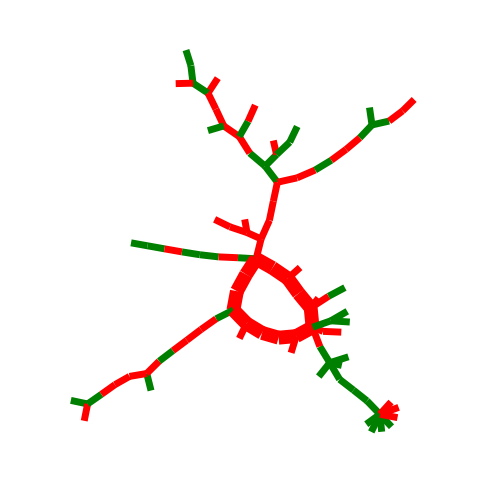

In [5]:
dataset.show(7)

In [6]:
model = NNConvClassifier(node_features=len(dataset.NODE_CLS),
                         edge_features=len(dataset.EDGE_CLS),
                         num_classes=len(dataset.GRAPH_CLS),
                         hidden_channels=32)
model.load_state_dict(torch.load('ckpts/cyclicity.pt'))

<All keys matched successfully>

In [7]:
dataset_list_gt = dataset.split_by_class()
dataset_list_pred = dataset.split_by_pred(model)

/opt/homebrew/Caskroom/mambaforge/base/envs/gnninterpreter/lib/python3.10/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The data of the dataset is already cached, so any modifications to `data` will not be reflected when accessing its elements. Clearing the cache now by removing all elements in `dataset._data_list`. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/opt/homebrew/Caskroom/mambaforge/base/envs/gnninterpreter/lib/python3.10/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you ar

In [8]:
evaluation = dataset.model_evaluate(model)
evaluation

{'acc': 0.9720199704170227,
 'cm': array([[2874,    0,   54],
        [   4, 2647,  126],
        [  69,   66, 5561]]),
 'f1': {'red_cyclic': 0.9783830046653748,
  'green_cyclic': 0.9642987251281738,
  'acyclic': 0.9724578261375427}}

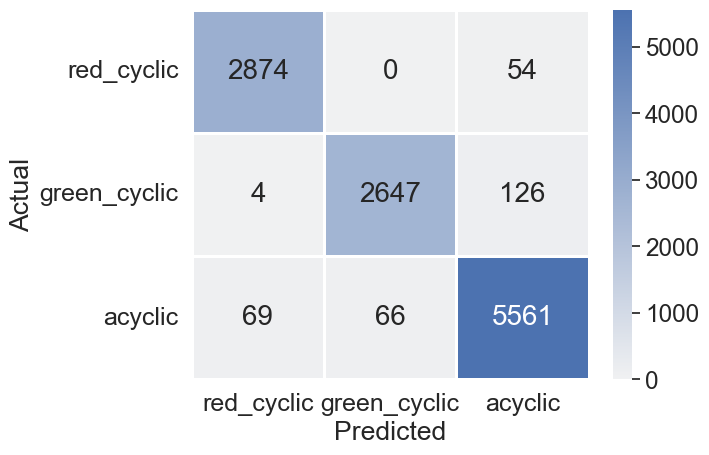

In [9]:
draw_matrix(evaluation['cm'], dataset.GRAPH_CLS.values(), fmt='d')

In [10]:
mean_embeds = [d.model_transform(model, key="embeds").mean(dim=0) for d in dataset_list_gt]

/opt/homebrew/Caskroom/mambaforge/base/envs/gnninterpreter/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [11]:
trainer = {}
sampler = {}

# Red Cyclic

In [12]:
cls_idx = 0
trainer[cls_idx] = Trainer(
    sampler=(s := GraphSampler(
        max_nodes=20,
        num_edge_cls=len(dataset.EDGE_CLS),
        temperature=0.15,
        learn_node_feat=False,
        learn_edge_feat=True
    )),
    discriminator=model,
    criterion=WeightedCriterion([
        dict(key="logits", criterion=ClassScoreCriterion(class_idx=cls_idx, mode='maximize'), weight=1),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_idx]), weight=1),
        dict(key="logits", criterion=MeanPenalty(), weight=1),
        dict(key="omega", criterion=NormPenalty(order=1), weight=2),
        dict(key="omega", criterion=NormPenalty(order=2), weight=2),
        # dict(key="xi", criterion=NormPenalty(order=1), weight=0),
        # dict(key="xi", criterion=NormPenalty(order=2), weight=0),
        dict(key="eta", criterion=NormPenalty(order=1), weight=0),
        dict(key="eta", criterion=NormPenalty(order=2), weight=0),
        dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=5),
    ]),
    optimizer=(o := torch.optim.SGD(s.parameters(), lr=1)),
    scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
    dataset=dataset,
    budget_penalty=BudgetPenalty(budget=10, order=2, beta=1),
)

In [13]:
cls_idx = 0
trainer[cls_idx].train(
    iterations=2000,
    target_probs={cls_idx: (0.9, 1.0)},
    target_size=20,
    w_budget_init=1,
    w_budget_inc=1.1,
    w_budget_dec=0.95,
    k_samples=16
)

  0%|          | 0/2000 [00:00<?, ?it/s]

True

n=17 m=19
logits=[101.8824234008789, -38.539520263671875, 16.946470260620117]
probs=[1.0, 0.0, 1.2965373911318937e-37]


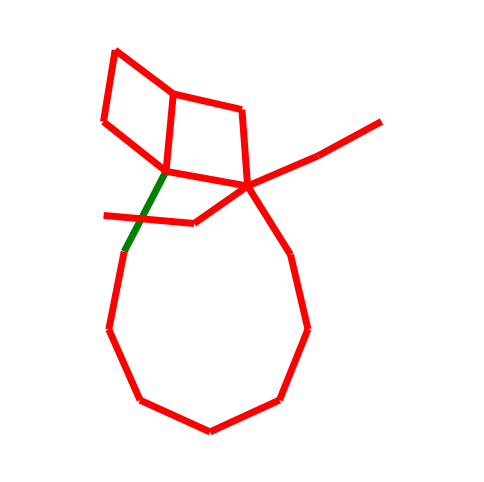

In [14]:
trainer[0].evaluate(threshold=0.5, show=True)

# Green Cyclic

In [15]:
cls_idx = 1
trainer[cls_idx] = Trainer(
    sampler=(s := GraphSampler(
        max_nodes=20,
        num_edge_cls=len(dataset.EDGE_CLS),
        temperature=0.15,
        learn_node_feat=False,
        learn_edge_feat=True
    )),
    discriminator=model,
    criterion=WeightedCriterion([
        dict(key="logits", criterion=ClassScoreCriterion(class_idx=cls_idx, mode='maximize'), weight=1),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_idx]), weight=1),
        dict(key="logits", criterion=MeanPenalty(), weight=1),
        dict(key="omega", criterion=NormPenalty(order=1), weight=2),
        dict(key="omega", criterion=NormPenalty(order=2), weight=2),
        # dict(key="xi", criterion=NormPenalty(order=1), weight=0),
        # dict(key="xi", criterion=NormPenalty(order=2), weight=0),
        dict(key="eta", criterion=NormPenalty(order=1), weight=0),
        dict(key="eta", criterion=NormPenalty(order=2), weight=0),
        dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=5),
    ]),
    optimizer=(o := torch.optim.SGD(s.parameters(), lr=1)),
    scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
    dataset=dataset,
    budget_penalty=BudgetPenalty(budget=10, order=2, beta=1),
)

In [16]:
cls_idx = 1
trainer[cls_idx].train(
    iterations=2000,
    target_probs={cls_idx: (0.9, 1.0)},
    target_size=20,
    w_budget_init=1,
    w_budget_inc=1.1,
    w_budget_dec=0.95,
    k_samples=16
)

  0%|          | 0/2000 [00:00<?, ?it/s]

True

n=4 m=4
logits=[9.884783744812012, 41.78472137451172, 13.449748992919922]
probs=[1.3996953485031875e-14, 1.0, 4.946270172959122e-13]


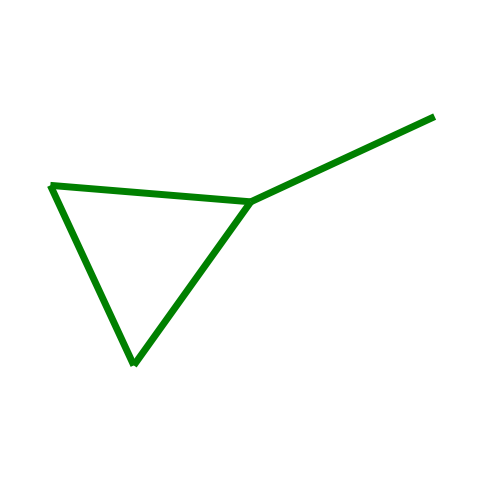

In [17]:
trainer[1].evaluate(threshold=0.5, show=True)

# Acyclic

In [18]:
cls_idx = 2
trainer[cls_idx] = Trainer(
    sampler=(s := GraphSampler(
        max_nodes=20,
        num_edge_cls=len(dataset.EDGE_CLS),
        temperature=0.15,
        learn_node_feat=False,
        learn_edge_feat=True
    )),
    discriminator=model,
    criterion=WeightedCriterion([
        dict(key="logits", criterion=ClassScoreCriterion(class_idx=cls_idx, mode='maximize'), weight=1),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_idx]), weight=1),
        dict(key="logits", criterion=MeanPenalty(), weight=1),
        dict(key="omega", criterion=NormPenalty(order=1), weight=2),
        dict(key="omega", criterion=NormPenalty(order=2), weight=2),
        # dict(key="xi", criterion=NormPenalty(order=1), weight=0),
        # dict(key="xi", criterion=NormPenalty(order=2), weight=0),
        dict(key="eta", criterion=NormPenalty(order=1), weight=0),
        dict(key="eta", criterion=NormPenalty(order=2), weight=0),
        dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=5),
    ]),
    optimizer=(o := torch.optim.SGD(s.parameters(), lr=1)),
    scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
    dataset=dataset,
    budget_penalty=BudgetPenalty(budget=10, order=2, beta=1),
)

In [19]:
cls_idx = 2
trainer[cls_idx].train(
    iterations=2000,
    target_probs={cls_idx: (0.9, 1.0)},
    target_size=20,
    w_budget_init=1,
    w_budget_inc=1.1,
    w_budget_dec=0.95,
    k_samples=16
)

  0%|          | 0/2000 [00:00<?, ?it/s]

True

n=16 m=19
logits=[-4.710405349731445, -8.151561737060547, 4.258912086486816]
probs=[0.00012723830877803266, 4.0751410779193975e-06, 0.999868631362915]


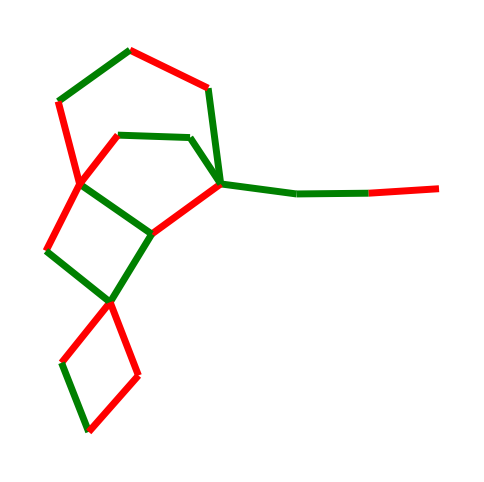

In [20]:
trainer[2].evaluate(threshold=0.5, show=True)